In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

Using TensorFlow backend.


In [2]:
CUSTOM = True

In [3]:
if not CUSTOM:
    
    DATA_DIR = './data/CamVid/'
    
    # load repo with data if it is not exists
    if not os.path.exists(DATA_DIR):
        print('Loading data...')
        os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial ./data')
        print('Done!')

In [4]:
if CUSTOM:
    DATA_DIR = './preprocess_data/data/'
    
    x_train_dir = os.path.join(DATA_DIR, 'train_images')
    y_train_dir = os.path.join(DATA_DIR, 'train_labels')

    x_valid_dir = os.path.join(DATA_DIR, 'valid_images')
    y_valid_dir = os.path.join(DATA_DIR, 'valid_labels')

    x_test_dir = os.path.join(DATA_DIR, 'test_images')
    y_test_dir = os.path.join(DATA_DIR, 'test_labels')
else:
    x_train_dir = os.path.join(DATA_DIR, 'train')
    y_train_dir = os.path.join(DATA_DIR, 'trainannot')

    x_valid_dir = os.path.join(DATA_DIR, 'val')
    y_valid_dir = os.path.join(DATA_DIR, 'valannot')

    x_test_dir = os.path.join(DATA_DIR, 'test')
    y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [5]:
ALLOWED_EXTENSIONS = ['jpg','JPG','jpeg','JPEG','png','PNG']
def allowed_file(filename):
    return '.' in filename and filename.rsplit('.', 1)[1].lower() in ALLOWED_EXTENSIONS

In [6]:
if CUSTOM:
    all_CLASSES = ['bg', 'cardigan',
                           'sweater',
                           'glove',
                           'hat',
                           'shorts',
                           'tie',
                           'hat',
                           'coat',
                           'skirt',
                           'shirt, blouse',
                           'jacket',
                           'pants',
                           'top, t-shirt, sweatshirt',
                           'dress',
                           'shoe',
                           'glasses',
                           'bag, wallet']
    
#     all_CLASSES = ['bg', 'shirt, blouse', 'top, t-shirt, sweatshirt', 'sweater', 'cardigan',
#        'jacket', 'pants', 'shorts', 'skirt', 'coat', 'dress', 'hat',
#        'tie', 'glove', 'shoe']
#     all_CLASSES = ['bg', 'cardigan', 'sequin', 'epaulette']
else:
    all_CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
                   'tree', 'signsymbol', 'fence', 'car', 
                   'pedestrian', 'bicyclist', 'unlabelled']

In [7]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    if CUSTOM:
        CLASSES = ['bg', 'cardigan',
                           'sweater',
                           'glove',
                           'hat',
                           'shorts',
                           'tie',
                           'hat',
                           'coat',
                           'skirt',
                           'shirt, blouse',
                           'jacket',
                           'pants',
                           'top, t-shirt, sweatshirt',
                           'dress',
                           'shoe',
                           'glasses',
                           'bag, wallet']
        
#         CLASSES = ['bg', 'shirt, blouse', 'top, t-shirt, sweatshirt', 'sweater', 'cardigan',
#        'jacket', 'pants', 'shorts', 'skirt', 'coat', 'dress', 'hat',
#        'tie', 'glove', 'shoe']
#         CLASSES = ['bg', 'cardigan', 'sequin', 'epaulette']
    else:
        CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
                   'tree', 'signsymbol', 'fence', 'car', 
                   'pedestrian', 'bicyclist', 'unlabelled']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = [filename for filename in os.listdir(images_dir) if allowed_file(filename)]
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        if CUSTOM:
            self.masks_fps = [os.path.join(masks_dir, image_id.split('.')[0] + '.npy') for image_id in self.ids]
        else:
            self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
#         print(self.masks_fps[i])
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, 1)
        if CUSTOM:
            mask = np.load(self.masks_fps[i])
        else:
            mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1 and not CUSTOM:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

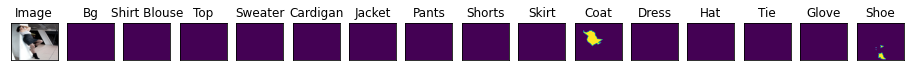

In [8]:
# Lets look at data we have
if CUSTOM:
    dataset = Dataset(x_train_dir, y_train_dir, classes=['bg', 'cardigan',
                           'sweater',
                           'glove',
                           'hat',
                           'shorts',
                           'tie',
                           'hat',
                           'coat',
                           'skirt',
                           'shirt, blouse',
                           'jacket',
                           'pants',
                           'top, t-shirt, sweatshirt',
                           'dress',
                           'shoe',
                           'glasses',
                           'bag, wallet'])
    dataset = Dataset(x_train_dir, y_train_dir, classes=all_CLASSES)
else:
    dataset = Dataset(x_train_dir, y_train_dir, classes=all_CLASSES)

image, mask = dataset[0] # get some sample
visualize(
    image=image, 
    BG=mask[..., 0].squeeze(),
    shirt_blouse=mask[..., 1].squeeze(),
    top=mask[..., 2].squeeze(),
    sweater=mask[..., 3].squeeze(),
    cardigan=mask[..., 4].squeeze(),
    jacket=mask[..., 5].squeeze(),
    pants=mask[..., 6].squeeze(),
    shorts=mask[..., 7].squeeze(),
    skirt=mask[..., 8].squeeze(),
    coat=mask[..., 9].squeeze(),
    dress=mask[..., 10].squeeze(),
    hat=mask[..., 11].squeeze(),
    tie=mask[..., 12].squeeze(),
    glove=mask[..., 13].squeeze(),
    shoe=mask[..., 14].squeeze()
)

In [9]:
import albumentations as A

In [10]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

#         A.HorizontalFlip(p=0.5),

#         A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        A.RandomCrop(height=320, width=320, always_apply=True),

#         A.IAAAdditiveGaussianNoise(p=0.2),
#         A.IAAPerspective(p=0.5),

#         A.OneOf(
#             [
#                 A.CLAHE(p=1),
#                 A.RandomBrightness(p=1),
#                 A.RandomGamma(p=1),
#             ],
#             p=0.9,
#         ),

#         A.OneOf(
#             [
#                 A.IAASharpen(p=1),
#                 A.Blur(blur_limit=3, p=1),
#                 A.MotionBlur(blur_limit=3, p=1),
#             ],
#             p=0.9,
#         ),

#         A.OneOf(
#             [
#                 A.RandomContrast(p=1),
#                 A.HueSaturationValue(p=1),
#             ],
#             p=0.9,
#         ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(384, 480)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)


def get_custom_test_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.Resize(384, 480),
        A.PadIfNeeded(384, 480)
    ]
    return A.Compose(test_transform)

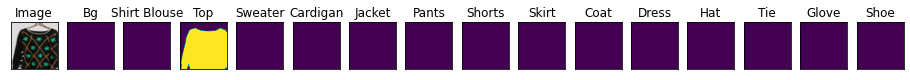

In [11]:
# Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=all_CLASSES, augmentation=get_training_augmentation())

image, mask = dataset[4] # get some sample
visualize(
    image=image, 
    BG=mask[..., 0].squeeze(),
    shirt_blouse=mask[..., 1].squeeze(),
    top=mask[..., 2].squeeze(),
    sweater=mask[..., 3].squeeze(),
    cardigan=mask[..., 4].squeeze(),
    jacket=mask[..., 5].squeeze(),
    pants=mask[..., 6].squeeze(),
    shorts=mask[..., 7].squeeze(),
    skirt=mask[..., 8].squeeze(),
    coat=mask[..., 9].squeeze(),
    dress=mask[..., 10].squeeze(),
    hat=mask[..., 11].squeeze(),
    tie=mask[..., 12].squeeze(),
    glove=mask[..., 13].squeeze(),
    shoe=mask[..., 14].squeeze()
)

In [12]:
import segmentation_models as sm

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`

Segmentation Models: using `keras` framework.


In [13]:
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 8
CLASSES = all_CLASSES
LR = 0.0001
EPOCHS = 50

preprocess_input = sm.get_preprocessing(BACKBONE)

In [14]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES))  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

In [15]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss() 
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [16]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 320, 320, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 320, 320, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
#     keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=False, mode='min'),
    keras.callbacks.ModelCheckpoint("./saved-model-{epoch:02d}-{val_iou_score:.2f}.hdf5", monitor='loss', verbose=1, save_best_only=False, mode='max'),
    keras.callbacks.ReduceLROnPlateau(),
]

In [ ]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/50
4901/4902 [============================>.] - ETA: 0s - loss: 0.8212 - iou_score: 0.4374 - f1-score: 0.4791

In [17]:
# # Plot training & validation iou_score values
# plt.figure(figsize=(30, 5))
# plt.subplot(121)
# plt.plot(history.history['iou_score'])
# plt.plot(history.history['val_iou_score'])
# plt.title('Model iou_score')
# plt.ylabel('iou_score')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')

# # Plot training & validation loss values
# plt.subplot(122)
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

In [17]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [18]:
# load best weights
# model.load_weights('./saved-model-06-0.82.hdf5')
model.load_weights('./models/saved-model-07-0.56.hdf5')

In [19]:
# scores = model.evaluate_generator(test_dataloader)

# print("Loss: {:.5}".format(scores[0]))
# for metric, value in zip(metrics, scores[1:]):
#     print("mean {}: {:.5}".format(metric.__name__, value))

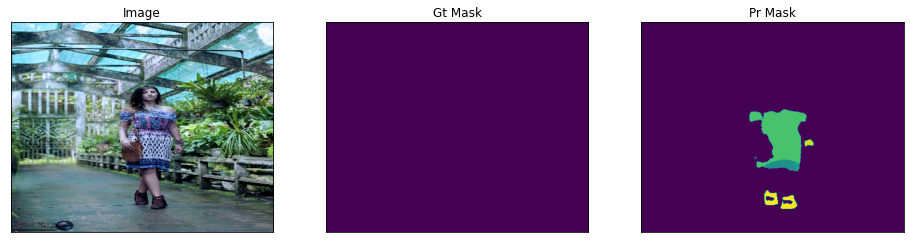

In [20]:
n = 1
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask.argmax(axis=2),
        pr_mask=pr_mask.squeeze().argmax(axis=2),
    )

In [21]:
all_CLASSES[10]

'dress'

In [22]:
pd.Series(gt_mask.argmax(axis=2).flatten()).value_counts()

0    184320
dtype: int64

In [23]:
pd.Series(pr_mask.squeeze().argmax(axis=2).flatten()).value_counts()

0     176219
10      6153
14       913
7        727
13       153
8        135
4         19
9          1
dtype: int64

In [24]:
# Indep gt

In [25]:
class DatasetCustom:

    if CUSTOM:
        CLASSES = ['bg', 'cardigan',
                           'sweater',
                           'glove',
                           'hat',
                           'shorts',
                           'tie',
                           'hat',
                           'coat',
                           'skirt',
                           'shirt, blouse',
                           'jacket',
                           'pants',
                           'top, t-shirt, sweatshirt',
                           'dress',
                           'shoe',
                           'glasses',
                           'bag, wallet']
        
#         CLASSES = ['bg', 'shirt, blouse', 'top, t-shirt, sweatshirt', 'sweater', 'cardigan',
#        'jacket', 'pants', 'shorts', 'skirt', 'coat', 'dress', 'hat',
#        'tie', 'glove', 'shoe']
#         CLASSES = ['bg', 'cardigan', 'sequin', 'epaulette']
    else:
        CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
                   'tree', 'signsymbol', 'fence', 'car', 
                   'pedestrian', 'bicyclist', 'unlabelled']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        
        self.ids = [filename for filename in os.listdir(images_dir) if allowed_file(filename)]
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        if CUSTOM:
            self.masks_fps = [os.path.join(masks_dir, image_id.split('.')[0] + '.npy') for image_id in self.ids]
        else:
            self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        print(self.images_fps[i])
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if CUSTOM:
            mask = np.load('./preprocess_data/data/test_labels/f749ed5fd5820b53ca8ea69816aadfaa.npy')
        else:
            mask = cv2.imread('./preprocess_data/data/test_labels/f749ed5fd5820b53ca8ea69816aadfaa.npy', 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1 and not CUSTOM:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    

In [26]:
indep_test_dataset = DatasetCustom(
    './preprocess_data/data/custom_test/', 
    y_test_dir,
    classes=CLASSES, 
    augmentation=get_custom_test_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

In [27]:
indep_test_dataset[9][0].shape

./preprocess_data/data/custom_test/26-fendi-women-fw-21-22-d96f51.jpg


(384, 480, 3)

In [28]:
indep_test_dataset[9][0]

./preprocess_data/data/custom_test/26-fendi-women-fw-21-22-d96f51.jpg


array([[[-0.59380084, -0.17997196,  0.56592613],
        [-0.57667613, -0.16246496,  0.5833553 ],
        [-0.7136741 , -0.30252096,  0.44392177],
        ...,
        [-2.0494049 , -1.7556022 , -1.2467101 ],
        [-2.0322802 , -1.7906162 , -1.2641394 ],
        [-2.0322802 , -1.8081232 , -1.2815686 ]],

       [[-1.2445416 , -0.84523803, -0.13124175],
        [-1.2787911 , -0.880252  , -0.16610013],
        [-1.3472902 , -0.9502801 , -0.23581691],
        ...,
        [-1.9980307 , -1.7731092 , -1.2815686 ],
        [-2.0151556 , -1.7906162 , -1.316427  ],
        [-2.0322802 , -1.7906162 , -1.3338562 ]],

       [[-1.9466565 , -1.6855742 , -1.1072767 ],
        [-1.9637812 , -1.6855742 , -1.1072767 ],
        [-1.9637812 , -1.6855742 , -1.1072767 ],
        ...,
        [-2.0151556 , -1.8606442 , -1.4210021 ],
        [-2.0494049 , -1.8431373 , -1.4384314 ],
        [-2.0494049 , -1.8431373 , -1.4384314 ]],

       ...,

       [[-1.1075436 , -1.0203081 , -0.7064052 ],
        [-1

./preprocess_data/data/custom_test/rick-owens-rtw-fw21-06-20900f.jpg


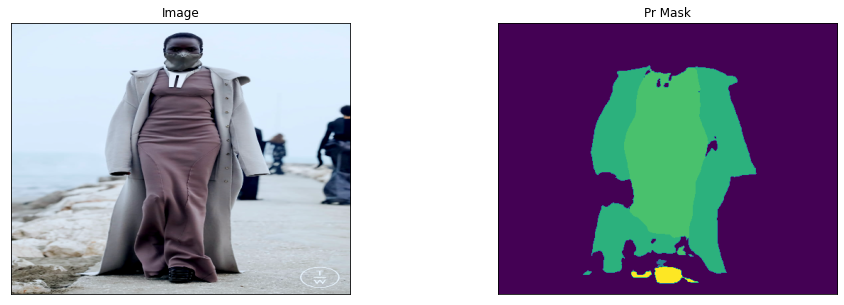

In [29]:
image, _ = indep_test_dataset[6]
image = np.expand_dims(image, axis=0)
pr_mask = model.predict(image)

visualize(
        image=denormalize(image.squeeze()),
#         gt_mask=gt_mask.argmax(axis=2),
        pr_mask=pr_mask.squeeze().argmax(axis=2),
    )

In [30]:
pd.Series(pr_mask.squeeze().argmax(axis=2).flatten()).value_counts()

0     136261
9      25691
10     21239
14      1034
6         95
dtype: int64

In [31]:
all_CLASSES[9]

'coat'

In [32]:
tmp = pr_mask.squeeze().argmax(axis=2)

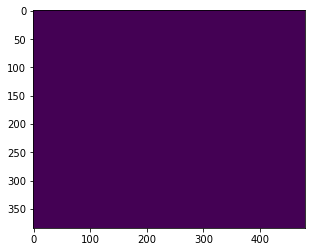

In [33]:
plt.imshow(np.where(tmp!=1, 0, tmp))

In [34]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb

In [35]:
label_image = pr_mask.squeeze().argmax(axis=2)

In [36]:
image_label_overlay = label2rgb(label_image, image=denormalize(image.squeeze()), bg_label=0)

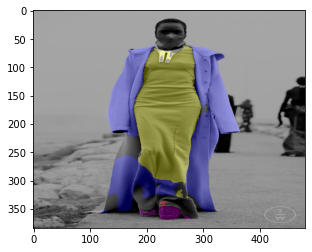

In [37]:
plt.imshow(image_label_overlay)

In [38]:
regionprops(label_image)[3].bbox

(345, 188, 369, 283)

In [39]:
regionprops(label_image)[2].bbox

(64, 178, 331, 297)

In [40]:
label_image.shape

(384, 480)

In [43]:
import matplotlib.colors as mcolors

In [53]:
next(iter())

'aliceblue'

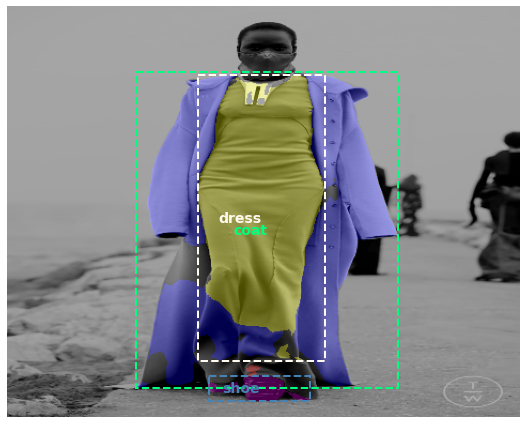

In [68]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)
text_colors = list(mcolors.CSS4_COLORS.keys())
np.random.shuffle(text_colors)
text_colors = iter(text_colors)

for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 500:
        text_color = next(text_colors)
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor=text_color, linewidth=2, label='Label', linestyle = 'dashed')
        ax.add_patch(rect)
        rx, ry = rect.get_xy()
        cx = rx + rect.get_width()/2.0
        cy = ry + rect.get_height()/2.0
        ax.annotate(all_CLASSES[region.label], (cx, cy), color=text_color, weight='bold', fontsize=14, ha='right', va='center')

ax.set_axis_off()
plt.tight_layout()
# plt.savefig('test.png')
plt.show()

In [82]:
ax

<AxesSubplot:>

In [40]:
plt.show()